In [ ]:
# # 베이스 구글 드라이브 폴더 설정
# RUN_GDRIVE_PATH = "lecture_"

# 1.사전 준비

## 1.1. Imports

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Base libraries
import os
import random

# Keras libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, Softmax
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.8.2


## 1.2.유틸

In [ ]:
def save_model(model_name: str, model: keras.models.Model):
    model_json = model.to_json()
    with open(model_name, "w") as json_file:
        json_file.write(model_json)

from keras.models import model_from_json
from typing import Optional

In [ ]:
def load_model(
    model_name: str, with_weights_path: Optional[str] = None
) -> keras.models.Model:
    json_file = open(model_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    if with_weights_path:
        model.load_weights(with_weights_path)
    return model

## 1.3.구글 드라이브 설정

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

여러분의 설정한 구글 드라이브의 폴더 이름을 넣습니다.

In [ ]:
# import os
# base_gdrive_path = os.path.join("drive", "MyDrive", RUN_GDRIVE_PATH)

설정한 구글 드라이브 폴더의 하위에 `results` 라는 이름의 폴더를 설정합니다.

In [ ]:
# from pathlib import Path
# import os

# result_path = os.path.join(base_gdrive_path, "results")
# Path(result_path).mkdir(parents=True, exist_ok=True)

# 2.Oxford IIIT Pet Dataset

우리는 이 데이터 세트 중, 이미지, 마스크를 활용하여 시맨틱 세그멘테이션을 진행합니다.

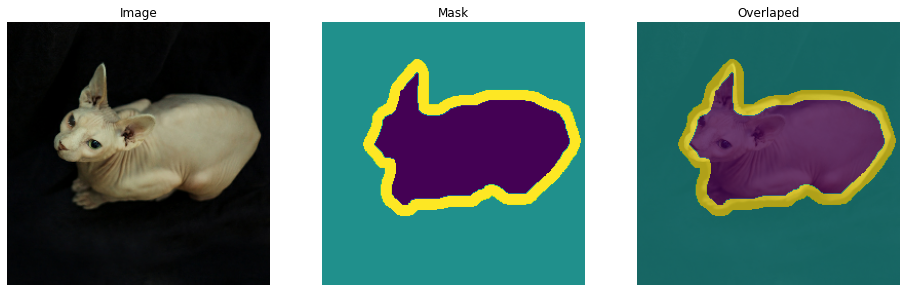

이 데이터 세트의 라벨 값은 다음과 같습니다.

- 1 : 전경
- 2 : 배경
- 3 : 테두리

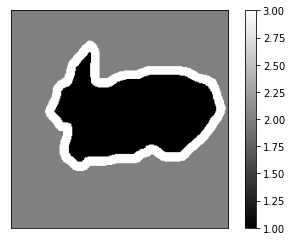

## 2.1.가져오기

tfds 라는 것을 활용하여 데이터를 가져옵니다.

https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

| 구분 | 개수 |
| --- | --- |
|'test'|3,669|
|'train'|3,680|


```
FeaturesDict({
    'file_name': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
```

https://www.tensorflow.org/datasets/api_docs/python/tfds/load

```python
tfds.load(
    name: str,
    *,
    split: Optional[Tree[splits_lib.SplitArg]] = None,
    data_dir: Optional[str] = None,
    batch_size: tfds.typing.Dim = None,
    shuffle_files: bool = False,
    download: bool = True,
    as_supervised: bool = False,
    decoders: Optional[TreeDict[decode.partial_decode.DecoderArg]] = None,
    read_config: Optional[tfds.ReadConfig] = None,
    with_info: bool = False,
    builder_kwargs: Optional[Dict[str, Any]] = None,
    download_and_prepare_kwargs: Optional[Dict[str, Any]] = None,
    as_dataset_kwargs: Optional[Dict[str, Any]] = None,
    try_gcs: bool = False
)
```

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteKIY10J/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteKIY10J/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


## 2.2.데이터 섞임 체크

[0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0]

종(`species`)은 잘 섞여있습니다.

[b'Sphynx_158.jpg',
 b'english_cocker_spaniel_135.jpg',
 b'British_Shorthair_181.jpg',
 b'Siamese_161.jpg',
 b'Sphynx_178.jpg',
 b'american_pit_bull_terrier_139.jpg',
 b'newfoundland_122.jpg',
 b'newfoundland_108.jpg',
 b'yorkshire_terrier_131.jpg',
 b'Bengal_149.jpg',
 b'Birman_127.jpg',
 b'saint_bernard_186.jpg',
 b'Siamese_175.jpg',
 b'chihuahua_187.jpg',
 b'german_shorthaired_150.jpg',
 b'basset_hound_136.jpg',
 b'newfoundland_165.jpg',
 b'english_cocker_spaniel_185.jpg',
 b'Siamese_154.jpg',
 b'Bengal_119.jpg',
 b'saint_bernard_127.jpg',
 b'Abyssinian_196.jpg',
 b'american_bulldog_178.jpg',
 b'american_pit_bull_terrier_183.jpg',
 b'japanese_chin_134.jpg',
 b'pug_190.jpg',
 b'Russian_Blue_191.jpg',
 b'boxer_104.jpg',
 b'great_pyrenees_14.jpg',
 b'pug_126.jpg',
 b'samoyed_145.jpg',
 b'english_cocker_spaniel_119.jpg',
 b'Birman_125.jpg',
 b'english_setter_178.jpg',
 b'english_cocker_spaniel_177.jpg',
 b'english_cocker_spaniel_158.jpg',
 b'american_bulldog_127.jpg',
 b'scottish_terrie

파일 이름(`file_name`)도 잘 섞여있는 것 같습니다.

## 2.3.이미지 크기 체크

[(500, 500, 3),
 (313, 500, 3),
 (500, 333, 3),
 (375, 500, 3),
 (500, 333, 3),
 (219, 300, 3),
 (400, 500, 3),
 (500, 333, 3),
 (191, 300, 3),
 (225, 300, 3),
 (375, 500, 3),
 (333, 500, 3),
 (375, 500, 3),
 (300, 200, 3),
 (500, 333, 3),
 (375, 500, 3),
 (333, 500, 3),
 (375, 500, 3),
 (375, 500, 3),
 (500, 356, 3),
 (334, 500, 3),
 (225, 300, 3),
 (334, 500, 3),
 (300, 225, 3),
 (500, 429, 3),
 (300, 274, 3),
 (500, 335, 3),
 (375, 500, 3),
 (333, 480, 3),
 (300, 203, 3),
 (375, 500, 3),
 (362, 500, 3),
 (500, 334, 3),
 (500, 365, 3),
 (500, 500, 3),
 (500, 372, 3),
 (334, 500, 3),
 (335, 500, 3),
 (500, 351, 3),
 (375, 500, 3),
 (334, 500, 3),
 (375, 500, 3),
 (180, 240, 3),
 (500, 350, 3),
 (252, 300, 3),
 (410, 500, 3),
 (900, 600, 3),
 (375, 500, 3),
 (333, 500, 3),
 (342, 500, 3),
 (500, 353, 3),
 (334, 500, 3),
 (292, 250, 3),
 (210, 300, 3),
 (500, 375, 3),
 (500, 333, 3),
 (375, 500, 3),
 (357, 500, 3),
 (334, 500, 3),
 (375, 500, 3),
 (482, 720, 3),
 (440, 500, 3),
 (373, 4

크기는 이미지 별로 제각각임을 확인할 수 있습니다.

In [ ]:
size_list = list(map(lambda ds_element: tf.keras.backend.int_shape(ds_element['image']), sample_ds))
size_list = list(map(lambda ds_size: (ds_size[0], ds_size[1]), size_list))

In [ ]:
print(f"최대 세로 : {max(list(map(lambda el: el[0], size_list)))}")
print(f"최소 세로 : {min(list(map(lambda el: el[0], size_list)))}")
print(f"최대 가로 : {max(list(map(lambda el: el[1], size_list)))}")
print(f"최소 가로 : {min(list(map(lambda el: el[1], size_list)))}")

최대 세로 : 900
최소 세로 : 163
최대 가로 : 720
최소 가로 : 200


전체 데이터 세트에 대해 봐도 크기는 다양합니다.

## 2.4.전환

위에서 이야기했듯, 이 데이터 세트는 여러 가지로 구성되어 있습니다.

```
FeaturesDict({
    'file_name': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
```

우리는 이 중에서, `image`, `segmentation_mask`만 필요하므로, 이것을 위한 데이터 세트로 전환합시다.

## 2.5.단일 데이터 살펴보기

데이터 세트 하나를 가져와서 살펴봅니다.

(<tf.Tensor: shape=(500, 500, 3), dtype=uint8, numpy=
 array([[[ 3,  3,  3],
         [ 5,  3,  4],
         [ 7,  5,  6],
         ...,
         [ 3,  1,  2],
         [ 3,  1,  2],
         [ 3,  1,  2]],
 
        [[ 4,  3,  1],
         [ 5,  3,  4],
         [ 5,  3,  4],
         ...,
         [ 6,  2,  3],
         [ 7,  3,  4],
         [ 8,  4,  5]],
 
        [[ 4,  3,  1],
         [ 5,  4,  2],
         [ 5,  3,  4],
         ...,
         [ 7,  3,  2],
         [ 8,  4,  3],
         [ 8,  4,  3]],
 
        ...,
 
        [[ 6, 10, 11],
         [ 6,  7,  9],
         [ 7,  8, 10],
         ...,
         [ 3,  4,  6],
         [ 3,  4,  6],
         [ 4,  5,  7]],
 
        [[ 8, 12, 13],
         [ 7,  8, 10],
         [ 8,  9, 11],
         ...,
         [ 4,  5,  9],
         [ 4,  5,  7],
         [ 4,  5,  7]],
 
        [[ 8, 12, 13],
         [ 7,  8, 10],
         [ 8,  9, 11],
         ...,
         [ 5,  6, 10],
         [ 5,  6, 10],
         [ 5,  6, 10]]], dt

In [ ]:
tf.unique_with_counts(tf.reshape(sample_data[1], (-1, )))

UniqueWithCounts(y=<tf.Tensor: shape=(3,), dtype=uint8, numpy=array([2, 3, 1], dtype=uint8)>, idx=<tf.Tensor: shape=(250000,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>, count=<tf.Tensor: shape=(3,), dtype=int32, numpy=array([169695,  24633,  55672], dtype=int32)>)

1. 이미지 - (height, width, 3)
    - RGB 컬러 이미지
2. 마스크 - (height, width, 1)
    - 1, 2, 3으로 구성된 마스크
        - 1 : 전경
        - 2 : 배경
        - 3 : 테두리

# 3.전처리

이미지는 그대로. 마스크는 변형합니다.

- 1(전경) -> 1(전경)
- 2(배경), 3(테두리) -> 0(배경)

변형 전후 비교

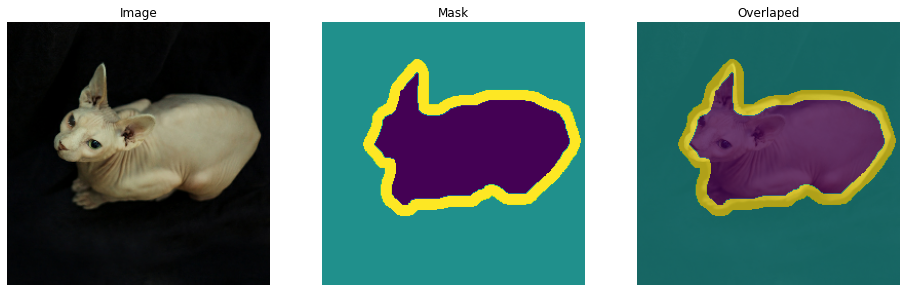

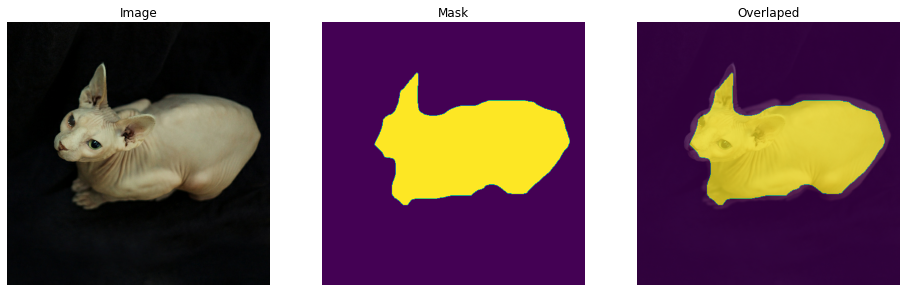

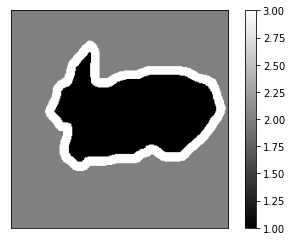

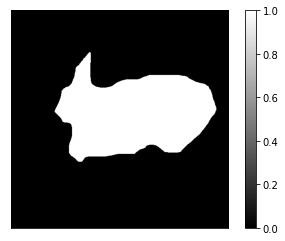

1) 할당

In [ ]:
train_binary_ds_1 = train_semantic_segmentation_ds
val_binary_ds_1 = val_semantic_segmentation_ds
test_binary_ds_1 = test_semantic_segmentation_ds

2) 리사이즈

In [ ]:
from typing import Tuple

In [ ]:
def image_mask_resize_1(
    image: tf.Tensor, 
    mask: tf.Tensor, 
    size: Tuple[int, int]) -> Tuple[tf.Tensor, tf.Tensor]:
    

In [ ]:
image_mask_resize_1_func = 

3) Normalize

4) 마스크 변환

- 1(전경) -> 1(전경)
- 2(배경), 3(테두리) -> 0(배경)

5) Cast

5) 결과

In [ ]:
sample_image_1, sample_mask_1 = list(train_binary_ds_1.take(1))[0]

In [ ]:
import matplotlib.pyplot as plt

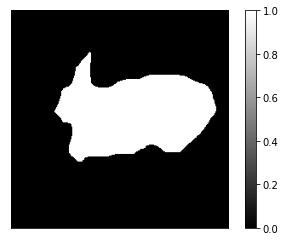

In [ ]:
# 이미지 플롯
plt.figure()
plt.imshow(tf.squeeze(sample_mask_1), cmap=plt.cm.binary.reversed())
plt.colorbar()
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

# 4.U-Net

## 4.1.모델

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
# U-Net
def unet(size=(256, 256, 3)):


In [ ]:
model = unet()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = [mean_iou])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 8)  0           ['conv2d_1[0][0]']           

## 4.2.모델 트레이닝

In [ ]:
def build_callbacks():
    checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
    callbacks = [checkpointer, PlotLearning()]
    return callbacks

# inheritance for training process plot 
import cv2

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1

        # [선택] 랜덤으로 검증 이미지 선택
        
        
        # [예측] 선택된 이미지에 대해 예측
        
        
        # [후처리] 예측 결과 후처리
        

        # [이미지 디스플레이] 필요 없는 배열 조절
        val_sample_img = tf.squeeze(val_sample_img)
        val_sample_mask = tf.squeeze(val_sample_mask)
        
        # [이미지 디스플레이] 이미지, 마스크 정리
        img = val_sample_img.numpy().astype(np.float32) 
        # rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        val_sample_mask = val_sample_mask[..., tf.newaxis].numpy()
        val_sample_mask = cv2.cvtColor(val_sample_mask, cv2.COLOR_GRAY2RGB)
        
        # [이미지 디스플레이] 디스플레이
        combined = np.concatenate([rgb_img, msk, rgb_img * msk, val_sample_mask], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

데이터 세트 배치로 전환

In [ ]:
BATCH_SIZE = 8

In [ ]:
batched_train_binary_ds_1 = 

Epoch 1/10
368/368 [==============================] - ETA: 0s - loss: 0.6003 - mean_iou: 0.0222

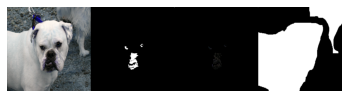

368/368 [==============================] - 57s 97ms/step - loss: 0.6003 - mean_iou: 0.0222 - val_loss: 0.5014 - val_mean_iou: 0.0206
Epoch 2/10
368/368 [==============================] - ETA: 0s - loss: 0.4638 - mean_iou: 0.4098

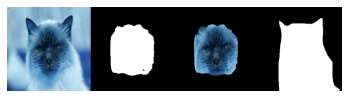

368/368 [==============================] - 39s 95ms/step - loss: 0.4638 - mean_iou: 0.4098 - val_loss: 0.4250 - val_mean_iou: 0.4701
Epoch 3/10
368/368 [==============================] - ETA: 0s - loss: 0.4377 - mean_iou: 0.4506

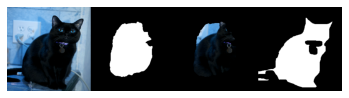

368/368 [==============================] - 39s 94ms/step - loss: 0.4377 - mean_iou: 0.4506 - val_loss: 0.4064 - val_mean_iou: 0.4975
Epoch 4/10
368/368 [==============================] - ETA: 0s - loss: 0.4117 - mean_iou: 0.4906

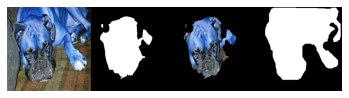

368/368 [==============================] - 39s 95ms/step - loss: 0.4117 - mean_iou: 0.4906 - val_loss: 0.3912 - val_mean_iou: 0.5568
Epoch 5/10
368/368 [==============================] - ETA: 0s - loss: 0.3772 - mean_iou: 0.5404

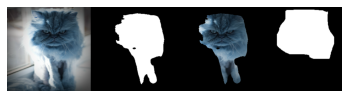

368/368 [==============================] - 39s 95ms/step - loss: 0.3772 - mean_iou: 0.5404 - val_loss: 0.3538 - val_mean_iou: 0.5544
Epoch 6/10
368/368 [==============================] - ETA: 0s - loss: 0.3530 - mean_iou: 0.5719

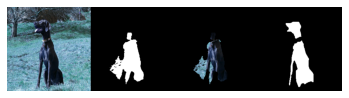

368/368 [==============================] - 40s 96ms/step - loss: 0.3530 - mean_iou: 0.5719 - val_loss: 0.3510 - val_mean_iou: 0.5735
Epoch 7/10
368/368 [==============================] - ETA: 0s - loss: 0.3393 - mean_iou: 0.5917

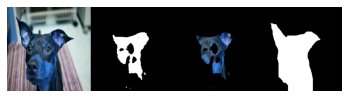

368/368 [==============================] - 40s 96ms/step - loss: 0.3393 - mean_iou: 0.5917 - val_loss: 0.3565 - val_mean_iou: 0.5379
Epoch 8/10
368/368 [==============================] - ETA: 0s - loss: 0.3236 - mean_iou: 0.6181

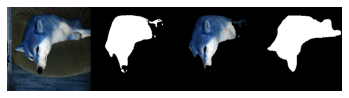

368/368 [==============================] - 39s 96ms/step - loss: 0.3236 - mean_iou: 0.6181 - val_loss: 0.3310 - val_mean_iou: 0.6284
Epoch 9/10
368/368 [==============================] - ETA: 0s - loss: 0.3074 - mean_iou: 0.6376

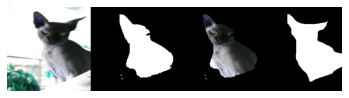

368/368 [==============================] - 40s 96ms/step - loss: 0.3074 - mean_iou: 0.6376 - val_loss: 0.3109 - val_mean_iou: 0.6455
Epoch 10/10
368/368 [==============================] - ETA: 0s - loss: 0.2958 - mean_iou: 0.6496

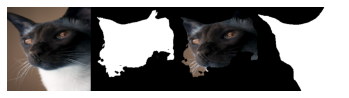

368/368 [==============================] - 40s 97ms/step - loss: 0.2958 - mean_iou: 0.6496 - val_loss: 0.3862 - val_mean_iou: 0.5946


In [ ]:
history = 

[0.022241968661546707, 0.40982022881507874, 0.4506317675113678, 0.49064871668815613, 0.5403812527656555, 0.5719297528266907, 0.591662585735321, 0.6180562376976013, 0.6375501751899719, 0.6495723128318787]
[0.020642248913645744, 0.4701032340526581, 0.4975370764732361, 0.5567564964294434, 0.5543950796127319, 0.5735442042350769, 0.5379446148872375, 0.6284043192863464, 0.6455093026161194, 0.5945752263069153]


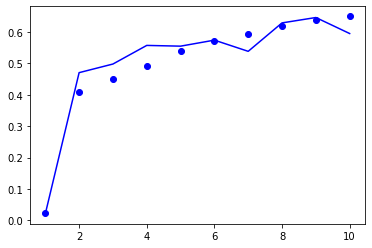

In [ ]:
history_accuracy = history.history["mean_iou"]
history_val_accuracy = history.history["val_mean_iou"]

epochs = range(1, len(history_accuracy) + 1)
plt.plot(epochs, history_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_val_accuracy, "b", label="Validation accuracy")

print(history_accuracy)
print(history_val_accuracy)

[0.6002891659736633, 0.4638020992279053, 0.43769511580467224, 0.41167470812797546, 0.37716221809387207, 0.3529662787914276, 0.33929020166397095, 0.32355615496635437, 0.30738672614097595, 0.295838862657547]
[0.5013631582260132, 0.42502954602241516, 0.4063999056816101, 0.39116817712783813, 0.3538106381893158, 0.35104021430015564, 0.35645750164985657, 0.33104267716407776, 0.3109362721443176, 0.38616734743118286]


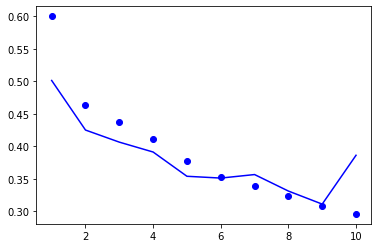

In [ ]:
history_loss = history.history["loss"]
history_val_loss = history.history["val_loss"]

epochs = range(1, len(history_loss) + 1)
plt.plot(epochs, history_loss, "bo", label="Training loss")
plt.plot(epochs, history_val_loss, "b", label="Validation loss")

print(history_loss)
print(history_val_loss)

## 4.3.모델 테스트 및 예측

In [ ]:
test_loss, test_acc = model.evaluate(batched_test_binary_ds_1)
print('테스트 정확도:', test_acc)

459/459 [==============================] - 19s 41ms/step - loss: 0.3741 - mean_iou: 0.6071
테스트 정확도: 0.6071293950080872


In [ ]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2022-08-10 01:57:16--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.227.254.124, 13.227.254.73, 13.227.254.63, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.227.254.124|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.002s  

2022-08-10 01:57:16 (33.3 MB/s) - ‘test.jpg’ saved [63219/63219]



In [ ]:
import cv2
img = cv2.imread('test.jpg')
img.shape

(720, 720, 3)

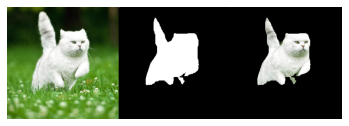

In [ ]:
# 이미지 전처리
img = cv2.imread('test.jpg')
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
img = img / 255.

# [예측] 선택된 이미지에 대해 예측
pred = model.predict(np.expand_dims(img, 0))

# [후처리] 예측 결과 후처리
msk = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0

# [이미지 디스플레이] 디스플레이
img = img.astype(np.float32) 
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
combined = np.concatenate([rgb_img, msk, rgb_img * msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

## 4.4.(선택) 모델 저장 및 불러와서 예측

In [ ]:
# save_model(os.path.join(result_path, "unet_000.json"), model)

# run_id = "001"
# weight_file_name = "unet_000__{}.hdf5".format(run_id)

# model.save_weights(os.path.join(result_path, weight_file_name))

In [ ]:
# json_model_path = os.path.join(result_path, "unet_000.json")
# model_weight_path = os.path.join(result_path, weight_file_name)
# loaded_model2_with_weight = load_model(json_model_path, model_weight_path)

In [ ]:
# img = cv2.imread('test.jpg')
# img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
# img = img / 255.

# # [예측] 선택된 이미지에 대해 예측
# pred = loaded_model2_with_weight.predict(np.expand_dims(img, 0))

# # [후처리] 예측 결과 후처리
# msk = pred.squeeze()
# msk = np.stack((msk,)*3, axis=-1)
# msk[msk >= 0.5] = 1 
# msk[msk < 0.5] = 0 

# # [이미지 디스플레이] 디스플레이
# img = img.astype(np.float32) 
# rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# combined = np.concatenate([rgb_img, msk, rgb_img * msk], axis = 1)
# plt.axis('off')
# plt.imshow(combined)
# plt.show()

# 5.U-Net 함수형 모델

In [ ]:
def unet_downsampling(input_layer, channel_num, do_max_pool=True):
    

def unet_bottleneck(input_layer, channel_num):
    

def unet_upsampling(input_layer, concat_layer, channel_num):
    


In [ ]:
def unet_func(image_size = (256, 256, 3)):
    base_channel = 16

    input = Input(image_size)

    # 다운 샘플링
    x_skip_1, x = unet_downsampling(input, base_channel)
    x_skip_2, x = unet_downsampling(x, base_channel*2)
    x_skip_3, x = unet_downsampling(x, base_channel*4)
    x_skip_4, x = unet_downsampling(x, base_channel*8, do_max_pool=False)

    # 병목
    x = unet_bottleneck(x, base_channel*16)

    # 업 샘플링
    x = unet_upsampling(x, x_skip_4, base_channel*8)
    x = unet_upsampling(x, x_skip_3, base_channel*4)
    x = unet_upsampling(x, x_skip_2, base_channel*2)
    x = unet_upsampling(x, x_skip_1, base_channel*1)

    # 픽셀 분류
    x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

    return Model(inputs=[input], outputs=[x])


In [ ]:
model_func_1 = unet_func()
model_func_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 16  2320        ['conv2d_28[0][0]']              
                                )                                                           

# 6.U-Net 커스텀 레이어 모델

In [ ]:
class UNetDownSamplingLayer(tf.keras.layers.Layer):
    


class UNetUpSamplingLayer(tf.keras.layers.Layer):
    


In [ ]:
def unet_custom_layer(image_size = (256, 256, 3)):
    base_channel = 16

    input = Input(image_size)

    # 다운 샘플링
    x_skip_1, x = UNetDownSamplingLayer(base_channel)(input)
    x_skip_2, x = UNetDownSamplingLayer(base_channel*2)(x)
    x_skip_3, x = UNetDownSamplingLayer(base_channel*4)(x)
    x_skip_4, x = UNetDownSamplingLayer(base_channel*8, False)(x)

    # 병목
    x = unet_bottleneck(x, base_channel*16)

    # 업 샘플링
    x = UNetUpSamplingLayer(base_channel*8)([x, x_skip_4])
    x = UNetUpSamplingLayer(base_channel*4)([x, x_skip_3])
    x = UNetUpSamplingLayer(base_channel*2)([x, x_skip_2])
    x = UNetUpSamplingLayer(base_channel*1)([x, x_skip_1])

    # 픽셀 분류
    x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

    return Model(inputs=[input], outputs=[x])

In [ ]:
model_cl_1 = unet_custom_layer()
model_cl_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 u_net_down_sampling_layer (UNe  ((None, 256, 256, 1  2768       ['input_3[0][0]']                
 tDownSamplingLayer)            6),                                                               
                                 (None, 128, 128, 1                                               
                                6))                                                               
                                                                                            